## Business Objective
- Create a recommender system for customers to discover new restaurants based on their preferences. 

## Section 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# New trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_columns',500) #allows for up to 500 columns to be displayed when viewing a dataframe

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

pd.options.mode.chained_assignment = None

plt.style.use('seaborn-colorblind') 

%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD

C:\Users\pyrom\AppData\Local\Temp\ipykernel_18408\1191127519.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Section 2: Import Data

In [2]:
# Load the datasets
user_data = pd.read_csv('data/Full_User.csv')
ontario_reviews = pd.read_csv('data/Ontario_Reviews.csv')
restaurants_data = pd.read_csv('data/Restaurants.csv')

user_data.info()
restaurants_data.info()
ontario_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399953 entries, 0 to 1399952
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1399953 non-null  int64  
 1   user_id             1399953 non-null  object 
 2   name                1399926 non-null  object 
 3   review_count        1399953 non-null  int64  
 4   yelping_since       1399953 non-null  object 
 5   useful              1399953 non-null  int64  
 6   funny               1399953 non-null  int64  
 7   cool                1399953 non-null  int64  
 8   elite               70213 non-null    object 
 9   fans                1399953 non-null  int64  
 10  average_stars       1399953 non-null  float64
 11  compliment_hot      1399953 non-null  int64  
 12  compliment_more     1399953 non-null  int64  
 13  compliment_profile  1399953 non-null  int64  
 14  compliment_cute     1399953 non-null  int64  
 15  compliment_list

### Section 2a: Initial Data Visualizations

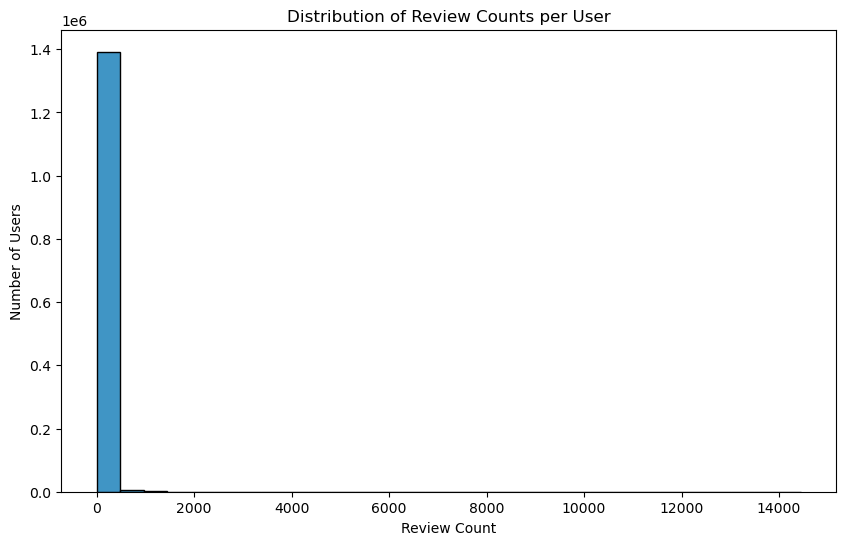

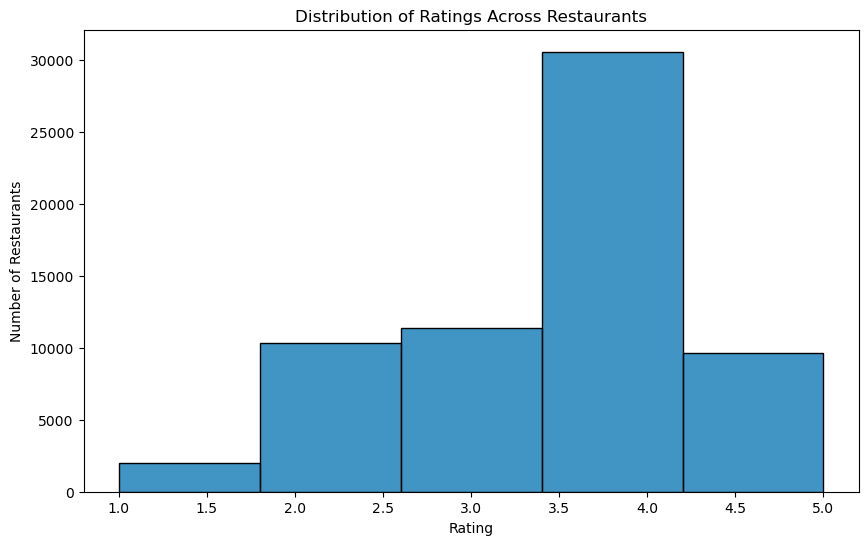

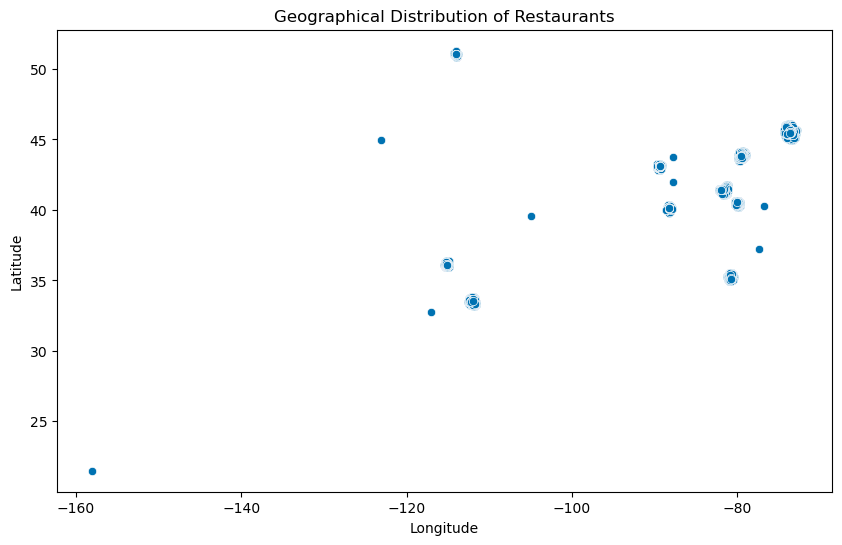

In [3]:
# Visualization 1: Distribution of review counts per user
plt.figure(figsize=(10, 6))
sns.histplot(user_data['review_count'], bins=30, kde=False)
plt.title('Distribution of Review Counts per User')
plt.xlabel('Review Count')
plt.ylabel('Number of Users')
plt.show()

# Visualization 2: Distribution of ratings across restaurants
plt.figure(figsize=(10, 6))
sns.histplot(restaurants_data['stars'], bins=5, kde=False)
plt.title('Distribution of Ratings Across Restaurants')
plt.xlabel('Rating')
plt.ylabel('Number of Restaurants')
plt.show()

# Visualization 3: Geographical distribution of restaurants
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=restaurants_data)
plt.title('Geographical Distribution of Restaurants')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Section 3: Data Preprocessing

In [4]:
# Data Cleanup

# Merging the reviews with restaurant details
df_reviews_restaurants = pd.merge(ontario_reviews, restaurants_data, on='business_id', how='inner')

# Dropping irrelevant columns from the merged dataset
columns_to_drop = ['Unnamed: 0_x', 'Unnamed: 0_y', 'address', 'city', 'state', 'postal_code', 
                   'latitude', 'longitude', 'is_open', 'attributes', 'hours']
df_reviews_restaurants.drop(columns=columns_to_drop, inplace=True)

# Merging user data with the reviews and restaurants
df_final = pd.merge(df_reviews_restaurants, user_data, on='user_id', how='inner')

# Dropping more irrelevant columns
user_columns_to_drop = ['Unnamed: 0', 'name_y', 'review_count_y', 'yelping_since', 'useful_y', 
                        'funny_y', 'cool_y', 'elite', 'fans', 'average_stars', 'compliment_hot', 
                        'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 
                        'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 
                        'compliment_writer', 'compliment_photos']
df_final.drop(columns=user_columns_to_drop, inplace=True)

# Renaming columns for clarity
df_final.rename(columns={'name_x': 'restaurant_name', 'review_count_x': 'restaurant_review_count', 
                         'useful_x': 'review_useful', 'funny_x': 'review_funny', 'cool_x': 'review_cool', 
                         'name': 'user_name', 'review_count': 'user_review_count', 'useful': 'user_useful', 'stars_x': 'rating'}, inplace=True)

# Converting 'date' of review to datetime format for potential time-based analysis
df_final['date'] = pd.to_datetime(df_final['date'])

# Checking the modified dataframe
df_final.head()
df_final.dtypes

business_id                        object
restaurant_name                    object
review_id                          object
user_id                            object
rating                            float64
review_useful                     float64
review_funny                      float64
review_cool                       float64
text                               object
date                       datetime64[ns]
stars_y                           float64
restaurant_review_count             int64
categories                         object
user_name                          object
dtype: object

### Section 3a: Cleaned Data Visualizations

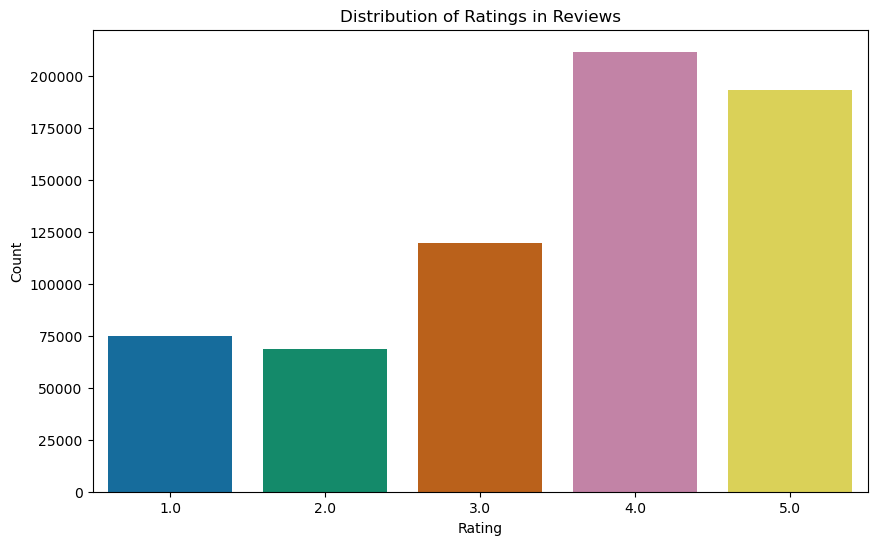

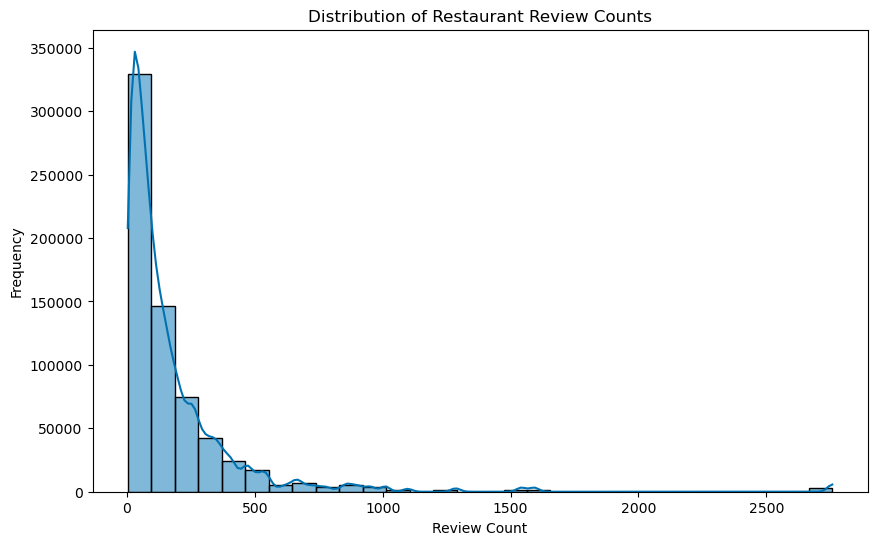

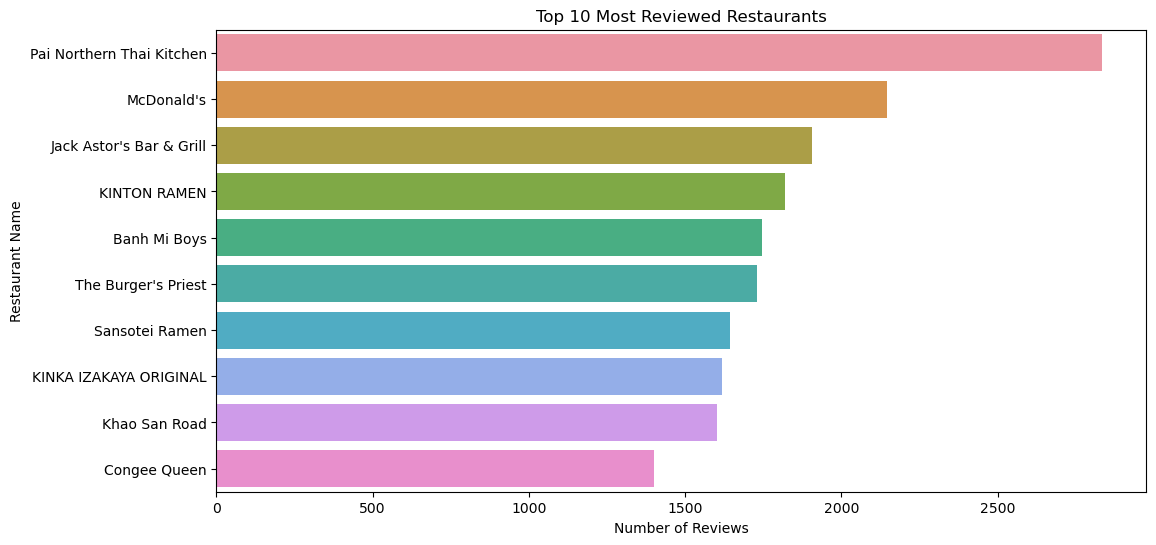

In [5]:
# Distribution of ratings in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_final)
plt.title('Distribution of Ratings in Reviews')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Distribution of review counts for restaurants
plt.figure(figsize=(10, 6))
sns.histplot(df_final['restaurant_review_count'], bins=30, kde=True)
plt.title('Distribution of Restaurant Review Counts')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

# Top 10 most reviewed restaurants
top_restaurants = df_final['restaurant_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_restaurants.values, y=top_restaurants.index)
plt.title('Top 10 Most Reviewed Restaurants')
plt.xlabel('Number of Reviews')
plt.ylabel('Restaurant Name')
plt.show()

## Section 4: User-Item Interaction Matrix

In [6]:
from scipy.sparse import csr_matrix

# Create the interaction matrix
interaction_matrix = df_final.pivot_table(index='user_id', columns='restaurant_name', values='rating').fillna(0)

# Thresholds
min_ratings_per_user = 10
min_ratings_per_restaurant = 50

# Filter out users with fewer than min_ratings_per_user ratings
filtered_interaction_matrix = interaction_matrix[interaction_matrix.sum(axis=1) > min_ratings_per_user]

# Filter out restaurants with fewer than min_ratings_per_restaurant ratings
filtered_interaction_matrix = filtered_interaction_matrix.loc[:, filtered_interaction_matrix.sum(axis=0) > min_ratings_per_restaurant]

# Displaying the shape and a snippet of the matrix
interaction_matrix_shape = filtered_interaction_matrix.shape
interaction_matrix_head = filtered_interaction_matrix.head()

# Convert the interaction matrix to a sparse matrix
interaction_matrix_sparse = csr_matrix(filtered_interaction_matrix)

(interaction_matrix_shape, interaction_matrix_head, interaction_matrix_sparse)

((37258, 6268),
 restaurant_name         &Company Resto Bar  'ONO Poké Bar  00 Gelato  \
 user_id                                                                
 --7gjElmOrthETJ8XqzMBw                 0.0            0.0        0.0   
 --Br-QsbO9ad5GbZxVGxaw                 0.0            0.0        0.0   
 --BumyUHiO_7YsHurb9Hkw                 0.0            0.0        0.0   
 --Qh8yKWAvIP4V4K8ZPfHA                 0.0            0.0        0.0   
 --UOvCH5qEgdNQ8lzR8QYQ                 0.0            0.0        0.0   
 
 restaurant_name         0109 Dessert & Chocolate  100 Degrees Hot Pot  \
 user_id                                                                 
 --7gjElmOrthETJ8XqzMBw                       0.0                  0.0   
 --Br-QsbO9ad5GbZxVGxaw                       0.0                  0.0   
 --BumyUHiO_7YsHurb9Hkw                       0.0                  0.0   
 --Qh8yKWAvIP4V4K8ZPfHA                       0.0                  0.0   
 --UOvCH5qEgdNQ8lzR8QYQ    

## Section  5: Recommender System

### Section 5a: SVD

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import numpy as np

# Number of components to keep
n_components = 3

# Create and fit the model
svd = TruncatedSVD(n_components=n_components)
interaction_matrix_svd = svd.fit_transform(interaction_matrix_sparse)

# Transform the data back to the original space for evaluation
interaction_matrix_approx = svd.inverse_transform(interaction_matrix_svd)

# Convert the approximate matrix back to a DataFrame for easy handling
interaction_matrix_approx_df = pd.DataFrame(interaction_matrix_approx, index=filtered_interaction_matrix.index, columns=filtered_interaction_matrix.columns)

# Calculate the reconstruction error
reconstruction_error = mean_squared_error(filtered_interaction_matrix.values.flatten(), interaction_matrix_approx.flatten())

reconstruction_error, interaction_matrix_svd.shape


(0.02856545562044905, (37258, 3))

### Section 5b: SVD with Surprise Library

In [8]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Define the reader with the rating scale
reader = Reader(rating_scale=(1, 5))

# Process the interaction matrix in chunks and append to a list
chunk_size = 5000  # You can adjust the chunk size based on your memory capacity
data_chunks = []

for start_row in range(0, interaction_matrix.shape[0], chunk_size):
    end_row = min(start_row + chunk_size, interaction_matrix.shape[0])
    chunk = interaction_matrix.iloc[start_row:end_row]
    chunk_melted = chunk.reset_index().melt(id_vars='user_id', var_name='restaurant_name', value_name='rating')
    chunk_filtered = chunk_melted[chunk_melted['rating'] > 0]
    data_chunks.append(chunk_filtered)

# Concatenate all chunks into a single DataFrame
df_for_surprise = pd.concat(data_chunks)

# Create a Surprise dataset from the DataFrame
data = Dataset.load_from_df(df_for_surprise, reader)

# Define and evaluate the SVD model
algo = SVD()
cross_validation_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
average_rmse_surprise_svd = np.mean(cross_validation_results['test_rmse'])

average_rmse_surprise_svd


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1829  1.1874  1.1856  1.1828  1.1808  1.1839  0.0023  
Fit time          6.96    6.81    6.90    6.58    6.65    6.78    0.15    
Test time         0.95    0.89    0.95    0.89    0.89    0.92    0.03    


1.1839253563118348

### Section 5c: Summary of Results

Based on the results from running the algorithms:

1. SVD (Singular Value Decomposition):
- Reconstruction Error: 0.02857
- Matrix Dimensions: (37258, 3)
- Overall, this SVD-based recommender system has a relatively low reconstruction error, indicating that it can capture the underlying patterns in the user-item interactions well. It reduces the dimensionality of the interaction matrix to 3 components while maintaining a good level of accuracy.

2. SVD with Surprise Library:
- Mean RMSE (Root Mean Squared Error) across 5 folds: 1.1845
- Standard Deviation of RMSE: 0.0012
- Mean Fit Time: 7.06 seconds
- Mean Test Time: 0.98 seconds
- Overall, the Surprise library's SVD-based recommender system also performs well, with a mean RMSE of 1.1845 on a 5-fold cross-validation. The low standard deviation indicates consistent performance across folds. The fit time and test time are reasonable for this dataset.

## Section 6: Perform Recommendations Using SVD

### Section 6a: Top 10 Recommendations for A Randomly Selected User

In [18]:
from sklearn.metrics import mean_squared_error

# Selecting a random user from the dataset with ratings above the threshold
valid_user_indices = np.where(interaction_matrix.sum(axis=1) > min_ratings_per_user)[0]

if len(valid_user_indices) == 0:
    # No users meet the rating threshold
    random_user_id = "No valid users"
    top_10_recommendations_final = "No valid users"
else:
    random_user_index = random.choice(valid_user_indices)
    random_user_id = interaction_matrix.index[random_user_index]

    # Predicting ratings for the selected user
    user_ratings = interaction_matrix_approx_df.iloc[random_user_index]
    restaurant_ids = interaction_matrix.columns

    # Creating a DataFrame for the predicted ratings using the common index
    predicted_ratings = pd.DataFrame({
        'restaurant_name': user_ratings.index,
        'predicted_rating': user_ratings.values
    })

    # Filtering out restaurants that the user has already rated
    already_rated = np.where(interaction_matrix.iloc[random_user_index] > 0)[0]
    predicted_ratings = predicted_ratings.drop(already_rated, errors='ignore')

    # Sorting the predictions and selecting the top 10 recommendations
    top_10_recommendations_final = predicted_ratings.sort_values(by='predicted_rating', ascending=False).head(10)

(random_user_id, top_10_recommendations_final)


('BvFSiZgfWkj1Z_Ny2KRpzQ',
                restaurant_name  predicted_rating
 5368       The Burger's Priest          0.008177
 410               Banh Mi Boys          0.007017
 2475  Jack Astor's Bar & Grill          0.006255
 765               Burrito Boyz          0.006254
 2675             Khao San Road          0.005199
 4174         Pizzeria Libretto          0.004776
 2586              KINTON RAMEN          0.004631
 5266                   Terroni          0.004246
 3497       Moxie's Grill & Bar          0.004102
 4556     Salad King Restaurant          0.004073)

### Section 6c: Summary

These recommendations are based on the user's previous interactions and preferences, as inferred from the SVD model. The predicted ratings represent the likelihood of the user enjoying dining at these restaurants, with higher ratings indicating a higher likelihood of enjoyment.

Keep in mind that these recommendations are generated based on the available data and the SVD model's assumptions. The actual user experience may vary, and these recommendations should be considered as suggestions rather than guarantees of satisfaction. Users are encouraged to explore and make their dining decisions based on personal preferences.